In [1]:
# In order to import the package from parent folder
import sys
sys.path[0] += '\\..'
import passion

import csv
import pathlib
import matplotlib.pyplot as plt
import shapely.wkt
import PIL
from PIL import ImageFont

In [2]:
result_path = pathlib.Path('R:/final/slurm/results/economic')
sections = passion.util.io.load_csv(result_path, 'lcoe.csv')

In [3]:
for section in sections:
    section['outline_latlon'] = list(shapely.wkt.loads(section['outline_latlon']).exterior.coords)
    section['outline_xy'] = list(shapely.wkt.loads(section['outline_xy']).exterior.coords)

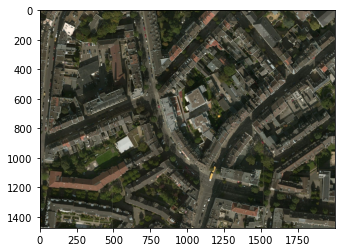

In [4]:
img_path = pathlib.Path('R:/final/slurm/results/satellite')
img_name = '50D46M24616SNORTH_06D04M36506SEAST_19L'
image = passion.util.io.load_image(img_path / (img_name + '.png'))

plt.imshow(image)

In [5]:
img_latlon, img_zoom = passion.util.gis.extract_filename(img_name)
img_bbox = passion.util.gis.get_image_bbox(img_latlon, img_zoom, image.shape[:2])

In [6]:
img_sections = []
for section in sections:
    if section['original_image_name'] == (img_name + '.png'):
        img_sections.append(section)

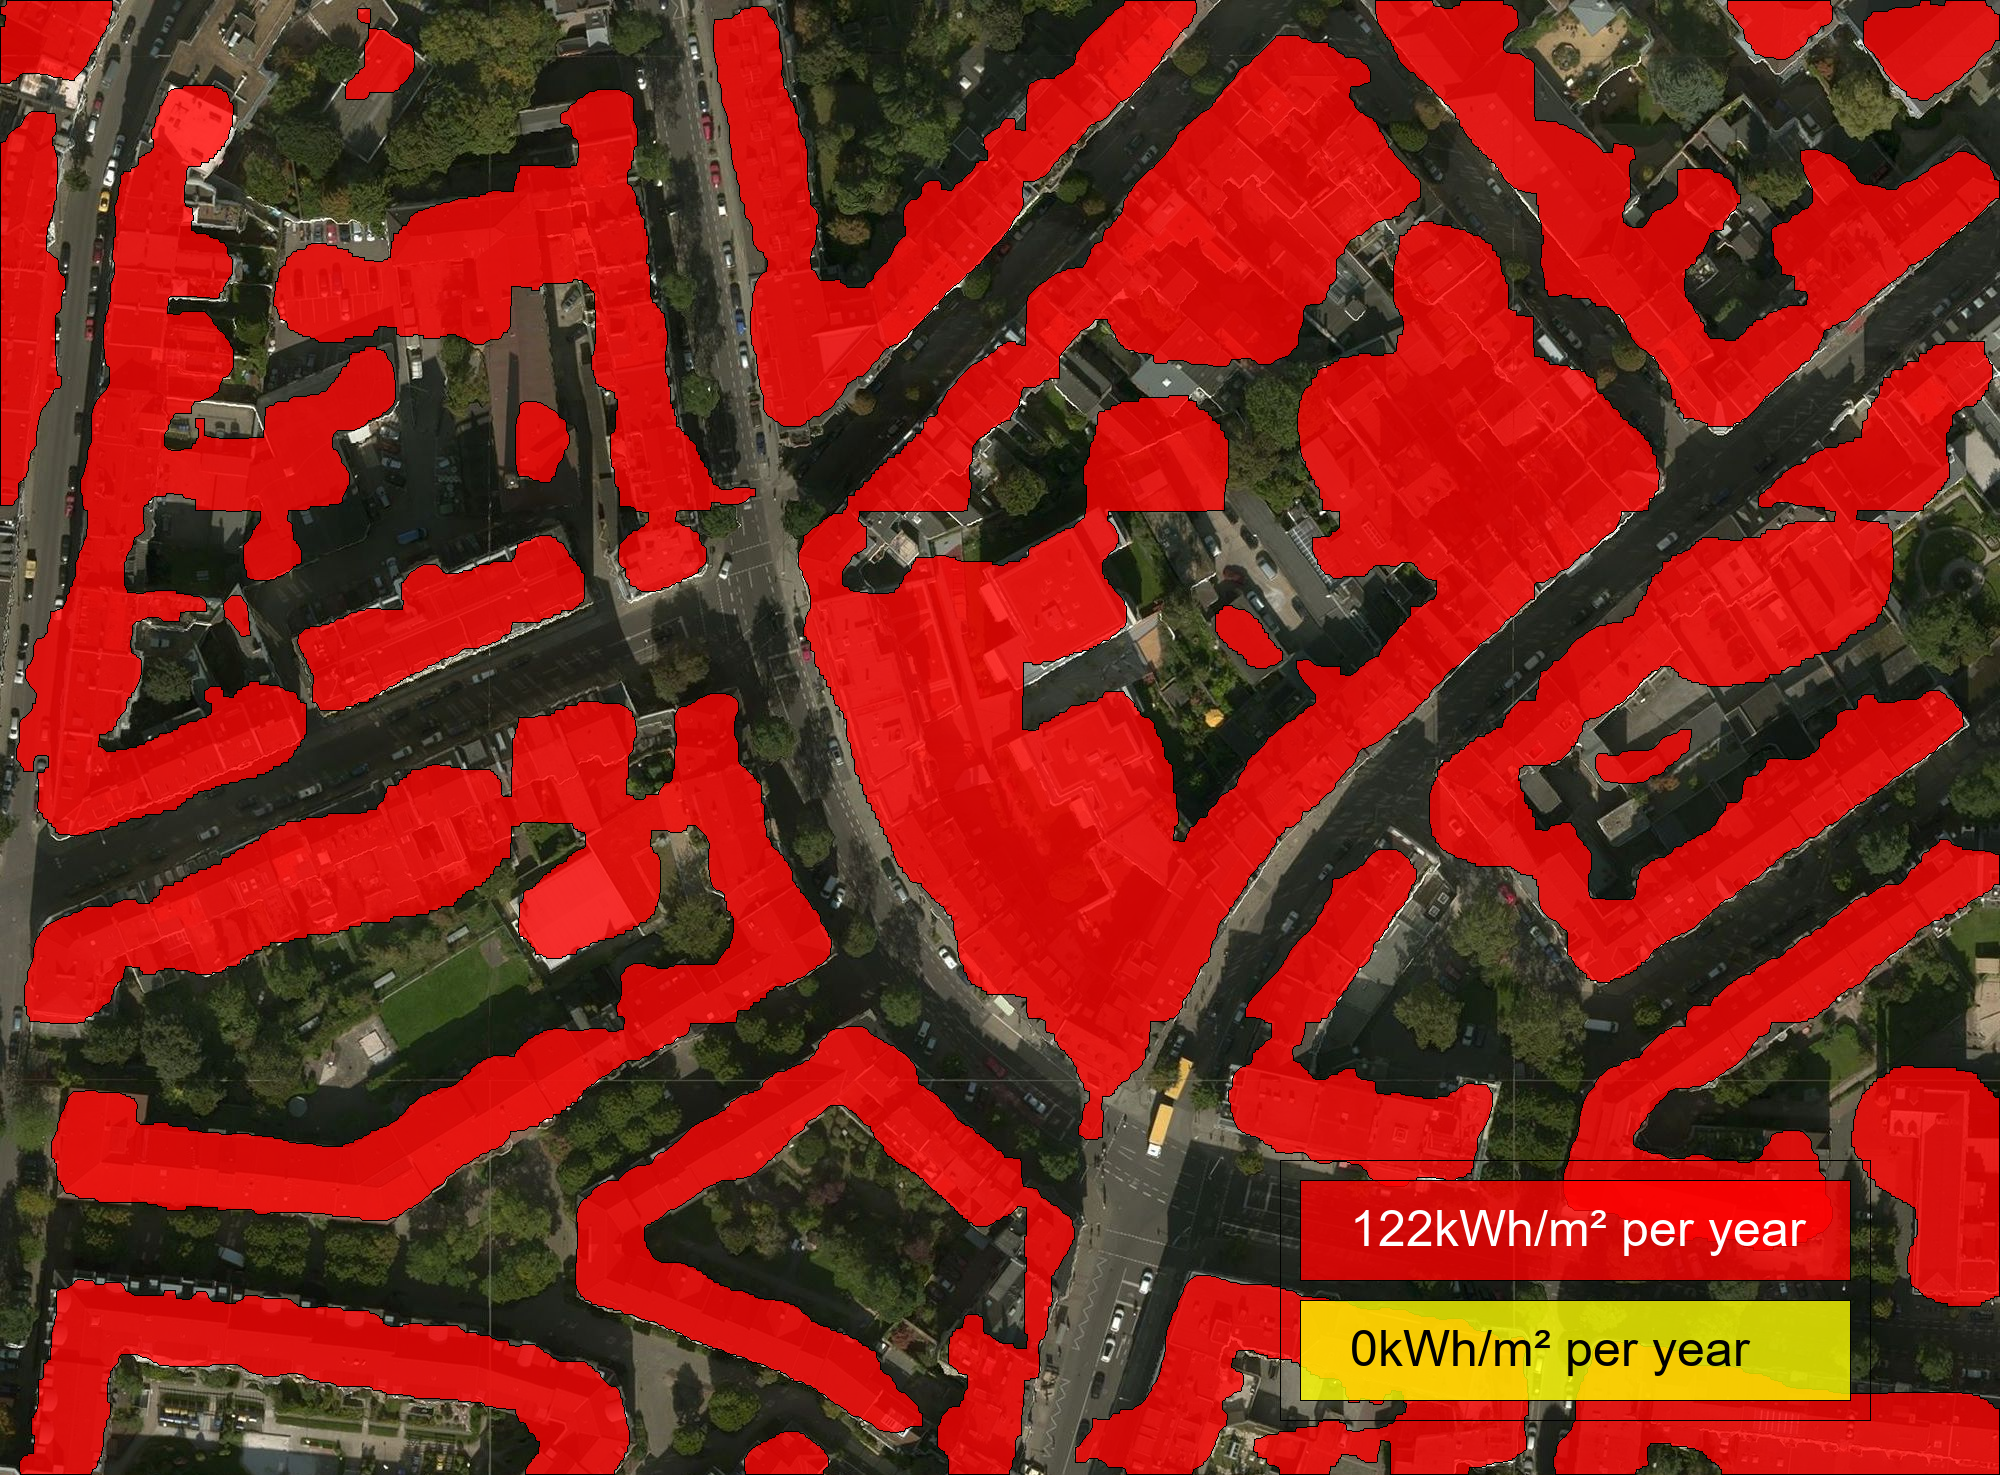

In [7]:
im_copy = PIL.Image.fromarray(image)

draw = PIL.ImageDraw.Draw(im_copy, 'RGBA')

max_gen = 0
max_prop = 0
for d in img_sections:
    max_gen = max(max_gen, d['yearly_gen'])
    max_prop = max(max_prop, d['yearly_gen'] / d['area'])
    
for section in img_sections:
    if not section['flat']:
        gen = section['yearly_gen']
        area = section['area']
        prop = gen / area

        gen_norm = gen / max_gen
        prop_norm = prop / max_prop

        intensity = int(prop_norm * 255)
        draw.polygon(list(section['outline_xy']), fill=(255, 300-intensity, 0, 200), outline=(0,0,0))
    if section['flat']:
        draw.polygon(list(section['outline_xy']), fill=(255, 0, 0, 200), outline=(0,0,0))

legend = [(1300,1180),(1850,1180),(1850,1280),(1300,1280)]
draw.polygon(legend, fill=(255,0,0,200), outline=(0,0,0))
legend = [(1300,1300),(1850,1300),(1850,1400),(1300,1400)]
draw.polygon(legend, fill=(255,255,0,200), outline=(0,0,0))
legend = [(1280, 1160), (1870, 1160), (1870, 1420), (1280, 1420)]
draw.polygon(legend, fill=(0,0,0,0), outline=(0,0,0))
font = ImageFont.truetype("arial.ttf", 50)
draw.text((1350,1200), str(int(max_prop/1000)) + 'kWh/m² per year', font=font, fill=(255,255,255,128))
draw.text((1350,1320), '0kWh/m² per year', font=font, fill=(0,0,0,128))

im_copy